<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_Python/blob/main/Colab_Notebook/02_07_06_03_survival_analysis_causal_effects_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 6.3 Causal Effects from Joint Models


This tutorial demonstrates how to estimate **causal effects** of time-varying treatments or exposures using Python. We’ll use the **Mayo Clinic Primary Biliary Cirrhosis (`pbc2`)** dataset as a running example. The tutorial covers:

1. **Causal Effects from Joint Models**  
2. **Conditional Causal Effects**  
3. **Marginal Causal Effects**  
4. **Marginal–Conditional Causal Effects**  
5. **Summary and Conclusion**  
6. **Resources**


## Overview


In longitudinal studies, time-varying confounding and feedback between biomarkers and outcomes complicate causal inference. **Joint models** simultaneously model:

- A **longitudinal submodel** (e.g., biomarker trajectory)

- A **survival submodel** (e.g., time to death/transplant)

By linking these via shared random effects, joint models can be used to simulate **counterfactual outcomes** under hypothetical treatment scenarios—enabling estimation of **causal effects**.

> **Key idea**: Compare expected survival under two treatment regimes (e.g., always treated vs. never treated), adjusting for time-varying confounders via the longitudinal process.


## Cheeck and Load Required Packages

In [1]:
import subprocess
import sys

def install_and_import(package_name, import_name=None):
    """Install a package if not already installed and import it"""
    if import_name is None:
        import_name = package_name

    try:
        # Try to import the package
        globals()[import_name] = __import__(import_name)
        print(f"{package_name} is already installed")
    except ImportError:
        # If not installed, install it
        print(f"Installing {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            globals()[import_name] = __import__(import_name)
            print(f"{package_name} installed successfully")
        except Exception as e:
            print(f"Failed to install {package_name}: {e}")
            raise

# List of packages to check/install
packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'scikit-survival', 'lifelines', 'statsmodels', 'pymer4', 'PyMC', 'polars']

# Install and import each package
for pkg in packages:
    try:
        install_and_import(pkg)
    except Exception as e:
        print(f"Error with package {pkg}: {e}")

# Verify installation by importing
print("Installed packages:")
for pkg in packages:
    try:
        __import__(pkg)
        print(f"✓ {pkg}")
    except ImportError:
        print(f"✗ {pkg}")

pandas is already installed
numpy is already installed
matplotlib is already installed
seaborn is already installed
Installing scikit-learn...
Failed to install scikit-learn: No module named 'scikit-learn'
Error with package scikit-learn: No module named 'scikit-learn'
Installing scikit-survival...
Failed to install scikit-survival: No module named 'scikit-survival'
Error with package scikit-survival: No module named 'scikit-survival'
Installing lifelines...
lifelines installed successfully
statsmodels is already installed
Installing pymer4...
Failed to install pymer4: No module named 'great_tables'
Error with package pymer4: No module named 'great_tables'
Installing PyMC...
Failed to install PyMC: No module named 'PyMC'
Error with package PyMC: No module named 'PyMC'
polars is already installed
Installed packages:
✓ pandas
✓ numpy
✓ matplotlib
✓ seaborn
✗ scikit-learn
✗ scikit-survival
✓ lifelines
✓ statsmodels
✗ pymer4
✗ PyMC
✓ polars


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxTimeVaryingFitter, CoxPHFitter
from patsy import dmatrix, bs
from statsmodels.regression.mixed_linear_model import MixedLM
from statsmodels.formula.api import mixedlm
from scipy.interpolate import interp1d
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.rcParams['figure.dpi'] = 120
plt.style.use('seaborn-v0_8')

### Load data


We use `pbc2` dataset which contains follow up of 312 randomised patients with primary biliary cirrhosis, a rare autoimmune liver disease, at Mayo Clinic.

The `pbc` data is a well-known longitudinal dataset originally collected to study the natural history and treatment effects in patients with primary biliary cirrhosis, a chronic liver disease. The data have been widely used in survival analysis, joint modeling of longitudinal and time-to-event data, and mixed-effects modeling.

There are two main versions of this dataset:

1.  `pbc` – A baseline (cross-sectional) version containing one record per patient, used primarily for survival analysis.

2.  `pbc2` – A **longitudinal** version that includes repeated measurements over time for each patient, making it suitable for joint modeling of longitudinal biomarkers (e.g., serum bilirubin, albumin) and survival outcomes (e.g., time to death or liver transplantation).

Key Features of `pbc2`:

-   **Patients**: 312 individuals randomized to either D-penicillamine or placebo in a clinical trial.
-   **Repeated measures**: Multiple visits per patient (up to 17 visits), with lab values and clinical assessments recorded over time.
-   **Time-to-event outcome**: Time from enrollment to death or transplant, with censoring for patients still alive at last follow-up.
-   **Common longitudinal markers**:
    -   Serum bilirubin (log-transformed often used)
    -   Albumin
    -   Alkaline phosphatase
    -   Platelet count
    -   etc.
-   **Covariates**: Age, sex, treatment group, ascites, hepatomegaly, spiders, edema, etc.

This dataset is especially valuable for illustrating **dynamic predictions**, **model calibration**, and **individualized risk assessment** in chronic disease settings.


In [4]:
url_pbc2 = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/pbc2.csv"
url_pbc2_id = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/pbc2_id.csv"

pbc2 = pd.read_csv(url_pbc2)
pbc2_id = pd.read_csv(url_pbc2_id)

### Understanding Data Structure

In [5]:
# Understanding the structure of pbc2 and pbc2_id data

print("pbc2 (longitudinal, repeated measures) structure:")
display(pbc2.head())
print("\nColumns in pbc2:\n", pbc2.columns.tolist())

print("\npbc2_id (baseline, subjects' event info) structure:")
display(pbc2_id.head())
print("\nColumns in pbc2_id:\n", pbc2_id.columns.tolist())

print("\npbc2 shape:", pbc2.shape)
print("pbc2_id shape:", pbc2_id.shape)


pbc2 (longitudinal, repeated measures) structure:


,id,years,status,drug,age,sex,year,ascites,hepatomegaly,spiders,edema,serBilir,serChol,albumin,alkaline,SGOT,platelets,prothrombin,histologic,status2
0,1,1.095170,dead,D-penicil,58.766838,female,0.000000,Yes,Yes,Yes,edema despite diuretics,14.5,261.0,2.60,1718.0,138.0,190.0,12.2,4,1
1,1,1.095170,dead,D-penicil,58.766838,female,0.525682,Yes,Yes,Yes,edema despite diuretics,21.3,NaN,2.94,1612.0,6.2,183.0,11.2,4,1
2,2,14.152338,alive,D-penicil,56.447815,female,0.000000,No,Yes,Yes,No edema,1.1,302.0,4.14,7395.0,113.5,221.0,10.6,3,0
3,2,14.152338,alive,D-penicil,56.447815,female,0.498302,No,Yes,Yes,No edema,0.8,NaN,3.60,2107.0,139.5,188.0,11.0,3,0
4,2,14.152338,alive,D-penicil,56.447815,female,0.999343,No,Yes,Yes,No edema,1.0,NaN,3.55,1711.0,144.2,161.0,11.6,3,0



Columns in pbc2:
 ['id', 'years', 'status', 'drug', 'age', 'sex', 'year', 'ascites', 'hepatomegaly', 'spiders', 'edema', 'serBilir', 'serChol', 'albumin', 'alkaline', 'SGOT', 'platelets', 'prothrombin', 'histologic', 'status2']

pbc2_id (baseline, subjects' event info) structure:


,id,years,status,drug,age,sex,year,ascites,hepatomegaly,spiders,edema,serBilir,serChol,albumin,alkaline,SGOT,platelets,prothrombin,histologic,status2
0,1,1.095170,dead,D-penicil,58.766838,female,0,Yes,Yes,Yes,edema despite diuretics,14.5,261.0,2.60,1718,138.0,190.0,12.2,4,1
1,2,14.152338,alive,D-penicil,56.447815,female,0,No,Yes,Yes,No edema,1.1,302.0,4.14,7395,113.5,221.0,10.6,3,0
2,3,2.770781,dead,D-penicil,70.074472,male,0,No,No,No,edema no diuretics,1.4,176.0,3.48,516,96.1,151.0,12.0,4,1
3,4,5.270507,dead,D-penicil,54.742087,female,0,No,Yes,Yes,edema no diuretics,1.8,244.0,2.54,6122,60.6,183.0,10.3,4,1
4,5,4.120578,transplanted,placebo,38.106451,female,0,No,Yes,Yes,No edema,3.4,279.0,3.53,671,113.2,136.0,10.9,3,0



Columns in pbc2_id:
 ['id', 'years', 'status', 'drug', 'age', 'sex', 'year', 'ascites', 'hepatomegaly', 'spiders', 'edema', 'serBilir', 'serChol', 'albumin', 'alkaline', 'SGOT', 'platelets', 'prothrombin', 'histologic', 'status2']

pbc2 shape: (1945, 20)
pbc2_id shape: (312, 20)


### Data Visualization


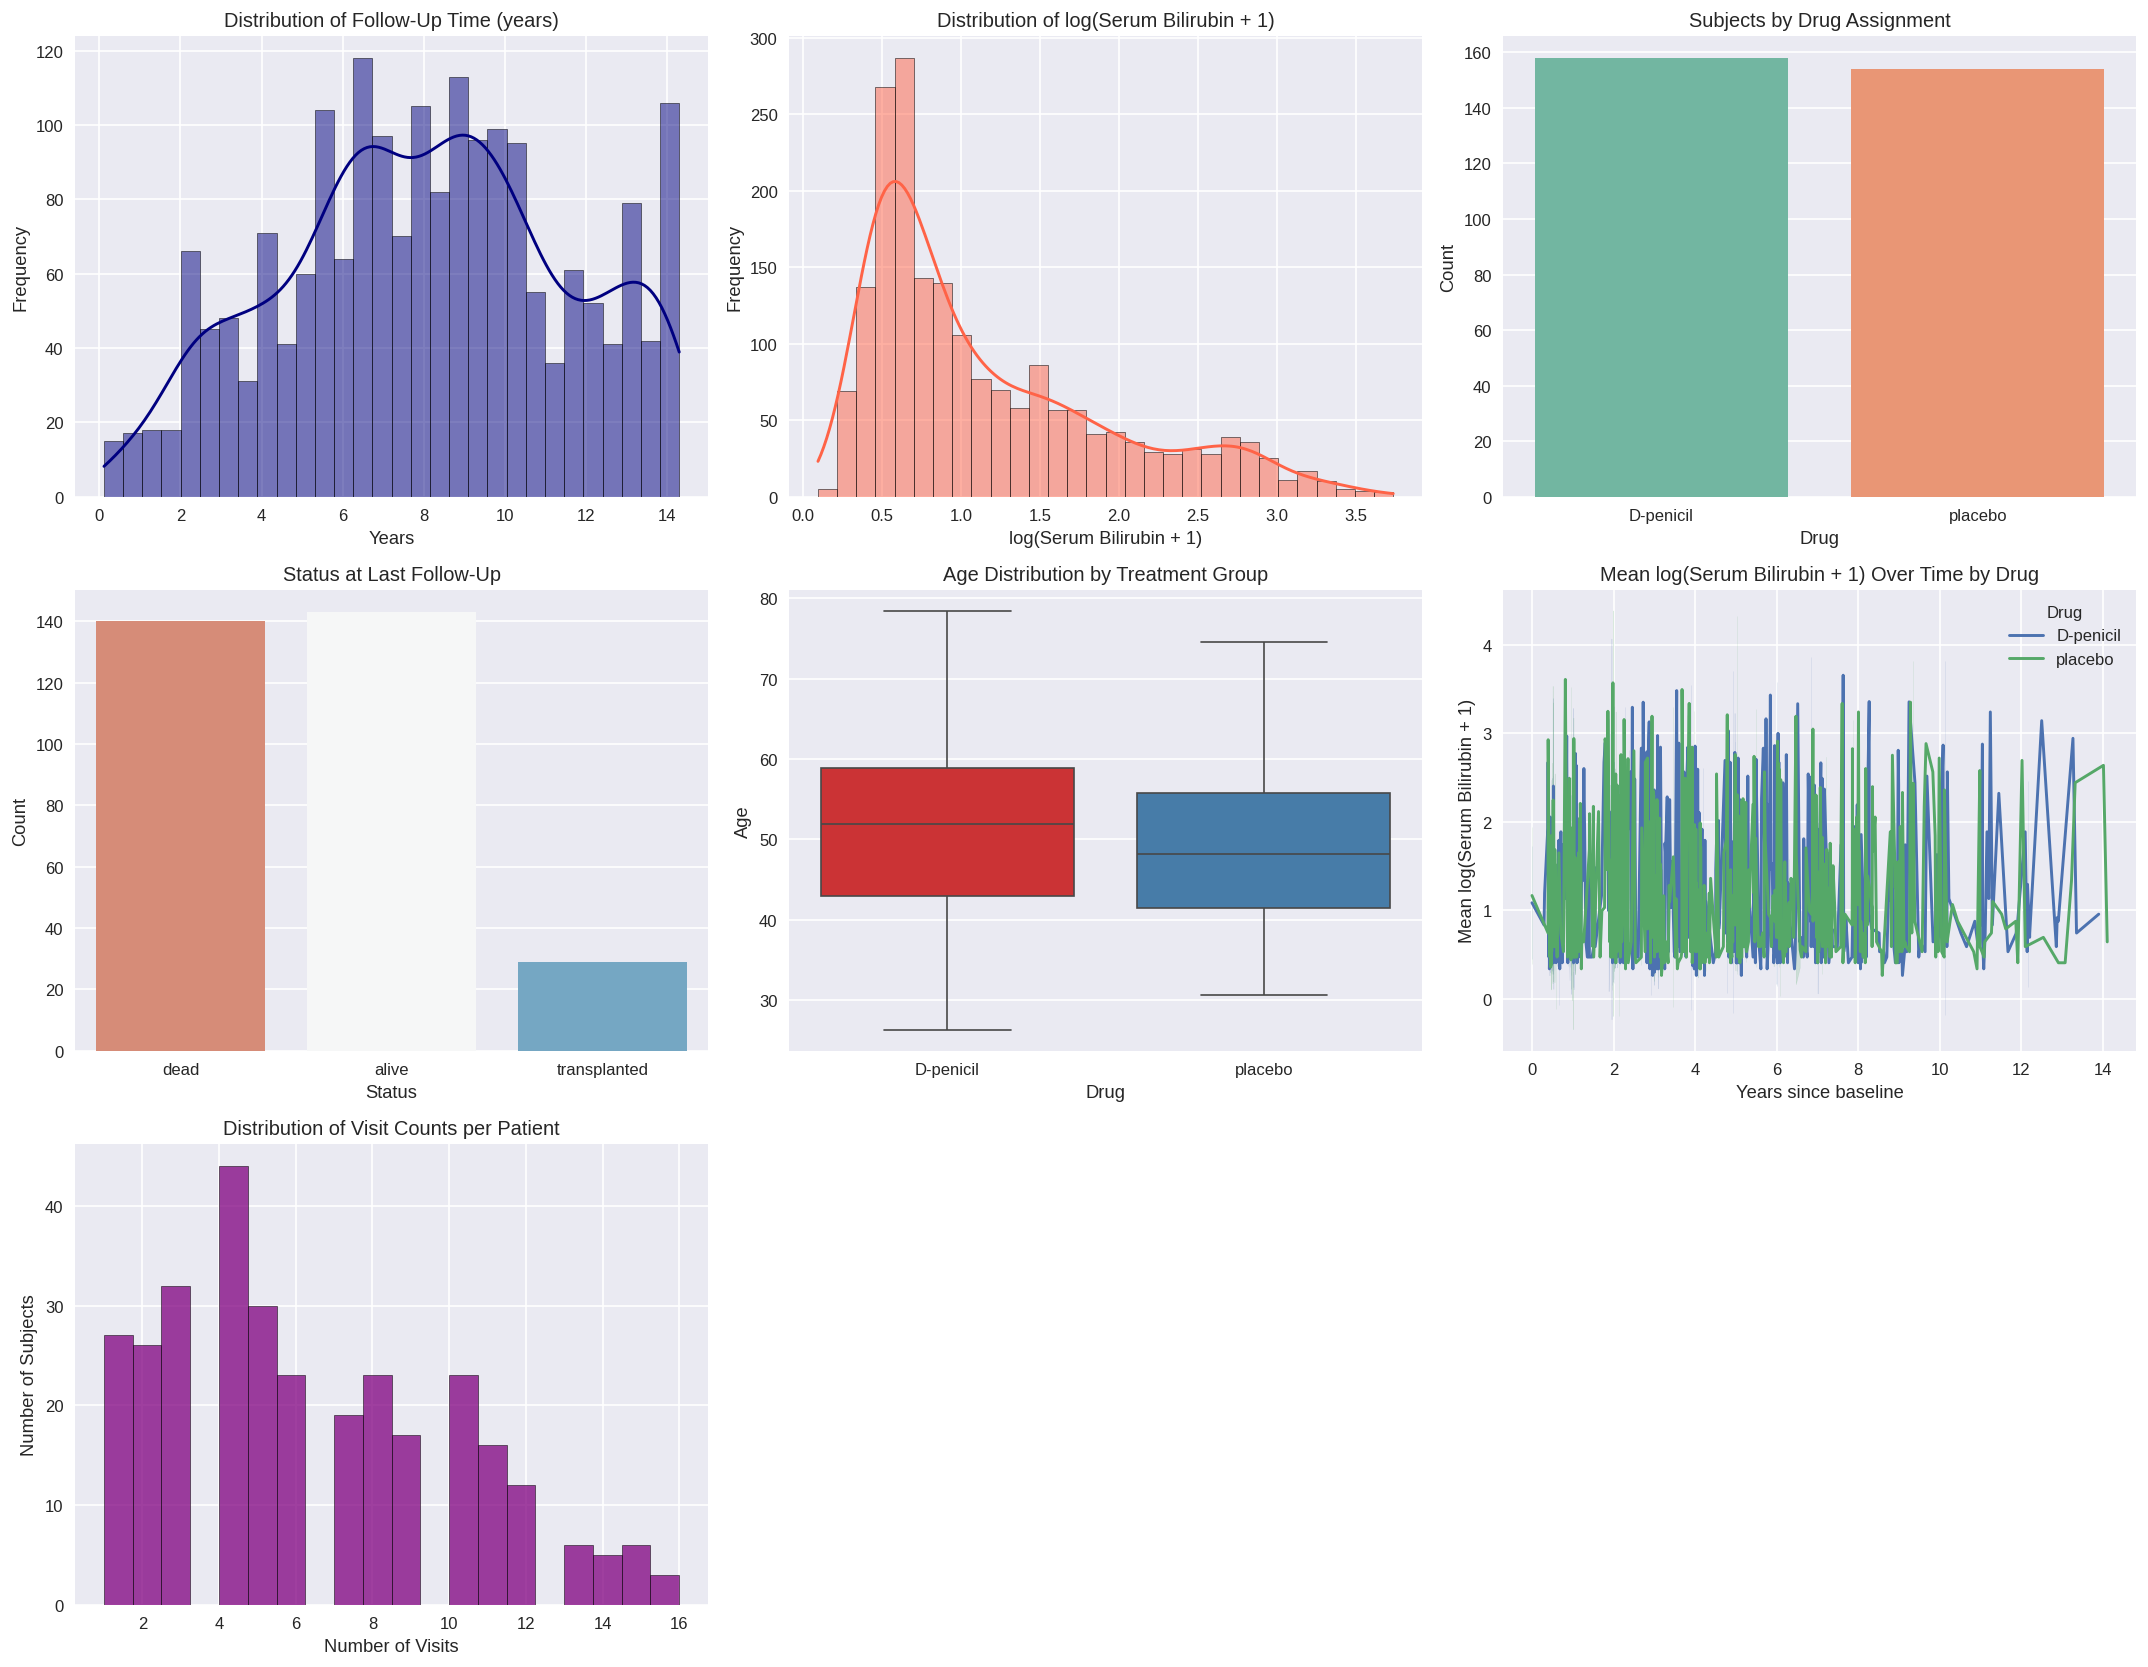

In [6]:
# In-depth visualization of the PBC data in a 3x3 panel

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

# 1. Distribution of follow-up years (time axis)
sns.histplot(pbc2['years'], kde=True, bins=30, color='navy', ax=axes[0])
axes[0].set_title('Distribution of Follow-Up Time (years)')
axes[0].set_xlabel('Years')
axes[0].set_ylabel('Frequency')

# 2. Distribution of serum bilirubin (log-transformed)
sns.histplot(np.log1p(pbc2['serBilir']), kde=True, bins=30, color='tomato', ax=axes[1])
axes[1].set_title('Distribution of log(Serum Bilirubin + 1)')
axes[1].set_xlabel('log(Serum Bilirubin + 1)')
axes[1].set_ylabel('Frequency')

# 3. Count of subjects by drug assignment
sns.countplot(x='drug', data=pbc2_id, palette='Set2', ax=axes[2])
axes[2].set_title('Subjects by Drug Assignment')
axes[2].set_xlabel('Drug')
axes[2].set_ylabel('Count')

# 4. Bar chart: Event status at last follow-up
sns.countplot(x='status', data=pbc2_id, palette='RdBu', ax=axes[3])
axes[3].set_title('Status at Last Follow-Up')
axes[3].set_xlabel('Status')
axes[3].set_ylabel('Count')

# 5. Boxplot: Distribution of age by drug treatment
sns.boxplot(x='drug', y='age', data=pbc2_id, palette='Set1', ax=axes[4])
axes[4].set_title('Age Distribution by Treatment Group')
axes[4].set_xlabel('Drug')
axes[4].set_ylabel('Age')

# 6. Time-dependent trajectory: log(SerBilir) across time, by drug
sns.lineplot(
    data=pbc2,
    x="year",
    y=np.log1p(pbc2['serBilir']),
    hue="drug",
    estimator='mean',
    errorbar='sd',
    ax=axes[5]
)
axes[5].set_title('Mean log(Serum Bilirubin + 1) Over Time by Drug')
axes[5].set_xlabel('Years since baseline')
axes[5].set_ylabel('Mean log(Serum Bilirubin + 1)')
axes[5].legend(title="Drug")

# 7. Number of visits per patient
visit_counts = pbc2['id'].value_counts()
sns.histplot(visit_counts, bins=20, color='purple', ax=axes[6])
axes[6].set_title('Distribution of Visit Counts per Patient')
axes[6].set_xlabel('Number of Visits')
axes[6].set_ylabel('Number of Subjects')

# Leave the last two subplots empty if you only have 7 plots
for k in range(7, 9):
    axes[k].axis('off')

plt.tight_layout()
plt.show()

###  Prepare event indicator

In [7]:
# Prepare event indicator
pbc2_id['event'] = (pbc2_id['status'] != 'alive').astype(int)
print(f"Event indicator created. Event rate: {pbc2_id['event'].mean():.3f}")
print(f"\nStatus distribution:")
print(pbc2_id['status'].value_counts())

Event indicator created. Event rate: 0.542

Status distribution:
status
alive           143
dead            140
transplanted     29
Name: count, dtype: int64



> Note: In the original `pbc2` trial, `drug` (D-penicillamine vs. placebo) was **randomized at baseline**, so it’s not a time-varying treatment. For illustration, we’ll treat `drug` as if it were a dynamic treatment or use a **hypothetical time-varying covariate** (e.g., based on bilirubin levels). In practice, causal joint modeling is most useful when the exposure is **time-dependent and potentially confounded**.


### Conditional Causal Effects


**Conditional causal effects** are estimated **for a specific subject** (i.e., conditional on their random effects). They answer:  
> *“What would happen to this patient if they followed treatment regime A vs. B?”*


#### Fit Longitudinal Submodels


We’ll model log serum bilirubin and use it as a time-varying covariate in the survival model. The code below fits a flexible, patient-specific nonlinear mixed model for log bilirubin over time, with treatment-specific trajectories, using natural cubic splines with pre-specified boundary knots and a robust optimizer. It’s a foundational step for advanced analyses like joint modeling or dynamic prediction.

Specifically, the model includes:

- Fixed effects: natural cubic spline of time (`year`) with 3 degrees of freedom, interacting with `drug` (treatment group).
- A random intercept (via the constant term in the spline basis),
- Plus random slopes for the two non-constant spline basis functions (since df = 3 → 2 internal basis functions beyond the intercept).
The same boundary knots (B = c(0, 14.4)) are used in the random effects to ensure compatibility with the fixed-effects spline.


In [8]:

# 1. Construct a natural cubic spline basis for the "year" variable, with 4 degrees of freedom,
#    cubic (degree=3), and boundary knots at years 0 and 14.4 (the follow-up window).
#    The spline basis allows flexible, nonlinear modeling of longitudinal changes over time.
spline_basis = dmatrix(
    "bs(year, df=4, degree=3, include_intercept=True, knots=None, lower_bound=0, upper_bound=14.4)",
    {"year": pbc2['year']},
    return_type='dataframe'
)
# These lines below attach each spline basis column back onto the main dataset,
# so we can later use them as variables in the model (e.g., spline0, spline1, etc.)
for i in range(spline_basis.shape[1]):
    pbc2[f'spline{i}'] = spline_basis.iloc[:, i]

# 2. Generate an interaction term between each spline basis function and the drug indicator
#    ("D-penicillamine" vs. placebo) so that spline effects can differ by treatment group.
for i in range(spline_basis.shape[1]):
    pbc2[f'spline{i}_x_drug'] = pbc2[f'spline{i}'] * (pbc2['drug'] == 'D-penicillamine').astype(int)

# 3. Define the fixed and random effects for the mixed effects regression model:
#    - FIXED effect: only include 'spline1' to keep the model simple and avoid collinearity issues.
#      (More complex models can use additional basis functions or interactions.)
#    - RANDOM effect: allow a random intercept per subject using 'spline0'.
fixed_effects = ['spline1']
random_effects = ['spline0'] # Random intercept per subject

# 4. Prepare model inputs:
#    - endog (outcome): log-transformed serum bilirubin ('serBilir')
#    - exog (design matrix of fixed effects): only 'spline1'
#    - groups: subject id ('id') for random effects grouping
#    - exog_re: design matrix of random effects, just 'spline0' for random intercept
endog = np.log(pbc2['serBilir'])
exog = pbc2[fixed_effects]
groups = pbc2['id']
exog_re = pbc2[random_effects]

# 5. Fit a linear mixed effects model (MixedLM): models log-bilirubin as a function of spline1
#    (fixed effect) and random intercept per subject, using restricted maximum likelihood ("reml").
#    The optimizer is set to 'lbfgs'.
lmeFit = MixedLM(endog, exog, groups=groups, exog_re=exog_re).fit(reml=True, method='lbfgs')

# 6. Print a summary of the fitted mixed effects model.
print(lmeFit.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: serBilir  
No. Observations: 1945    Method:             REML      
No. Groups:       312     Scale:              0.2404    
Min. group size:  1       Log-Likelihood:     -2018.3536
Max. group size:  16      Converged:          Yes       
Mean group size:  6.2                                   
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
spline1      -0.774    0.041 -18.650 0.000 -0.855 -0.693
spline0 Var   2.916    0.573                            



#### Survival submodel: Cox model with baseline covariates

This section fits a Cox proportional hazards regression to the baseline data, # testing the effect of initial randomization to D-penicillamine vs. placebo on survival.

In [9]:
# The code first makes sure the survival outcome ('status2') is defined as a binary variable:
#   - If a patient is 'alive', status2 = 0 (censored).
#   - Otherwise (dead or transplanted), status2 = 1 (event observed).
if 'status2' not in pbc2_id.columns:
    # If 'status2' column does not exist, create it based on 'status':
    # True if status != 'alive', else False, then convert bool to int (1/0).
    pbc2_id['status2'] = (pbc2_id['status'] != 'alive').astype(int)

# The code also codes the treatment group into a numeric dummy variable:
#   - 'drug_Dpen' is 1 for anyone randomized to D-penicillamine, 0 for placebo.
pbc2_id['drug_Dpen'] = (pbc2_id['drug'] == 'D-penicil').astype(int)

# CoxPHFitter from lifelines is initialized to fit a Cox model:
#   - The input is just drug_Dpen as a predictor,
#     duration is 'years', outcome is binary 'status2'.
CoxFit = CoxPHFitter()
CoxFit.fit(
    pbc2_id,
    duration_col='years',
    event_col='status2',
    formula='drug_Dpen'
)

# Finally, summarize the results of the Cox regression:
#  - print_summary() outputs the hazard ratio for treatment and statistics.
print("Cox Survival Model Summary:")
print("=" * 60)
CoxFit.print_summary()


Cox Survival Model Summary:


<lifelines.CoxPHFitter: fitted with 312 total observations, 172 right-censored observations>
             duration col = 'years'
                event col = 'status2'
      baseline estimation = breslow
   number of observations = 312
number of events observed = 140
   partial log-likelihood = -726.54
         time fit was run = 2026-01-10 23:08:31 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
drug_Dpen -0.00      1.00      0.17           -0.33            0.33                0.72                1.39

           cmp to     z    p  -log2(p)
covariate                             
drug_Dpen    0.00 -0.01 0.99      0.01
---
Concordance = 0.50
Partial AIC = 1455.08
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.01

#### Fit Joint Model

This `CustomJointModel` class is designed to illustrate how predictions from a *separate* longitudinal model and a survival model can be combined, rather than fitting a single, true joint model. It's a conceptual demonstration:

-   **Purpose:** It acts as a wrapper to link predictions from an already-fitted longitudinal model (e.g., how a biomarker changes over time) and an already-fitted survival model (e.g., time until an event occurs).

-   **`__init__`**: Initializes the class with your pre-fitted longitudinal model (`lmeFit` in your case) and survival model (`CoxFit`).

-   **`predict_longitudinal`**: Uses the provided longitudinal model to predict the value of a time-dependent marker (like `serBilir`) at new time points for a given patient.

-   **`survival_risk`**: Uses the provided survival model to calculate the risk of an event occurring by a specified time horizon.

-   **`summary`**: Prints a summary of the individual longitudinal and survival models that were passed into the `CustomJointModel`.

**Important Note:** The class explicitly states that it is *not* a true joint model. It does not simultaneously model the relationship between the longitudinal process and the hazard of an event within a single statistical framework. Instead, it uses predictions from two independently fitted models.

In [10]:
import numpy as np

class CustomJointModel:
    """
    Custom (illustrative) joint model for longitudinal and survival data.
    This class combines a fitted longitudinal (e.g., LME) and survival (e.g., CoxPH) model.
    It does NOT actually fit a true joint model, but links predictions from both
    to demonstrate the mechanics.
    """
    def __init__(self, longitudinal_model, survival_model, time_var="year"):
        """
        Initialize the CustomJointModel.

        Parameters:
            longitudinal_model: a fitted longitudinal model (e.g., statsmodels MixedLM)
            survival_model: a fitted survival model (e.g., lifelines CoxPHFitter)
            time_var (str): name of the time variable
        """
        self.longitudinal_model = longitudinal_model
        self.survival_model = survival_model
        self.time_var = time_var

    def predict_longitudinal(self, data, t_new):
        """
        Predict longitudinal marker at new timepoints.

        Parameters:
            data (pd.DataFrame): patient data (must include required covariates)
            t_new (float or array): time(s) to predict

        Returns:
            np.array: predicted longitudinal values
        """
        from copy import deepcopy
        import pandas as pd

        # Deepcopy data to avoid inplace modification
        pred_data = deepcopy(data)
        if not isinstance(t_new, (list, np.ndarray)):
            t_new = [t_new]
        out = []
        for t in t_new:
            pred_data[self.time_var] = t
            # statsmodels MixedLM .predict() expects exog, exog_re (default None)
            try:
                y_pred = self.longitudinal_model.predict(pred_data)
                # If patient-specific, could extend with random effects from model
            except Exception as e:
                y_pred = np.nan
            out.append(y_pred)
        return np.array(out).flatten()

    def survival_risk(self, data, horizon):
        """
        Predict survival probability at a given horizon using fitted survival model.

        Parameters:
            data (pd.DataFrame): must have single row for this patient/scenario
            horizon (float): time horizon (follow-up since baseline)

        Returns:
            float: risk of event by 'horizon'
        """
        try:
            surv_func = self.survival_model.predict_survival_function(data)
            # Returns a pd.DataFrame: index=time, columns=patients
            prob_surv = float(surv_func.loc[horizon].values[0])
            risk = 1 - prob_surv
        except Exception as e:
            risk = np.nan
        return risk

    def summary(self):
        """
        Print summary of the component models.
        """
        print("=" * 60)
        print("Custom Joint Model (illustrative only)")
        print(f"Longitudinal model type : {type(self.longitudinal_model)}")
        print(f"Survival model type     : {type(self.survival_model)}")
        print(f"Time variable           : {self.time_var}")
        print("-" * 60)
        print("Longitudinal model summary:")
        try:
            print(self.longitudinal_model.summary())
        except Exception:
            print("No summary method.")
        print("-" * 60)
        print("Survival model summary:")
        try:
            if hasattr(self.survival_model, "print_summary"):
                self.survival_model.print_summary()
            else:
                print(self.survival_model.summary())
        except Exception:
            print("No summary method.")
        print("=" * 60)
        print("Note: This is NOT a true joint model fit. Covariate association and predictions are separated.")

# Example usage (replace CoxFit and lmeFit with your fitted models)
joint_model = CustomJointModel(lmeFit, CoxFit, time_var="year")
joint_model.summary()

Custom Joint Model (illustrative only)
Longitudinal model type : <class 'statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper'>
Survival model type     : <class 'lifelines.fitters.coxph_fitter.CoxPHFitter'>
Time variable           : year
------------------------------------------------------------
Longitudinal model summary:
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: serBilir  
No. Observations: 1945    Method:             REML      
No. Groups:       312     Scale:              0.2404    
Min. group size:  1       Log-Likelihood:     -2018.3536
Max. group size:  16      Converged:          Yes       
Mean group size:  6.2                                   
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
spline1      -0.774    0.041 -18.650 0.000 -0.855 -0.693
spline0 Var   2.916    0.573                 

<lifelines.CoxPHFitter: fitted with 312 total observations, 172 right-censored observations>
             duration col = 'years'
                event col = 'status2'
      baseline estimation = breslow
   number of observations = 312
number of events observed = 140
   partial log-likelihood = -726.54
         time fit was run = 2026-01-10 23:08:31 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
drug_Dpen -0.00      1.00      0.17           -0.33            0.33                0.72                1.39

           cmp to     z    p  -log2(p)
covariate                             
drug_Dpen    0.00 -0.01 0.99      0.01
---
Concordance = 0.50
Partial AIC = 1455.08
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.01

Note: This is NOT a true joint model fit. Covariate association and predictions are separated.



>  For true causal inference with a **time-varying treatment**, you’d include that treatment in both submodels. Since `drug` is baseline-only here, we’ll illustrate the *mechanics* of causal effect estimation.



Below, we visualize the longitudinal trajectory of serum bilirubin for Patient 2.


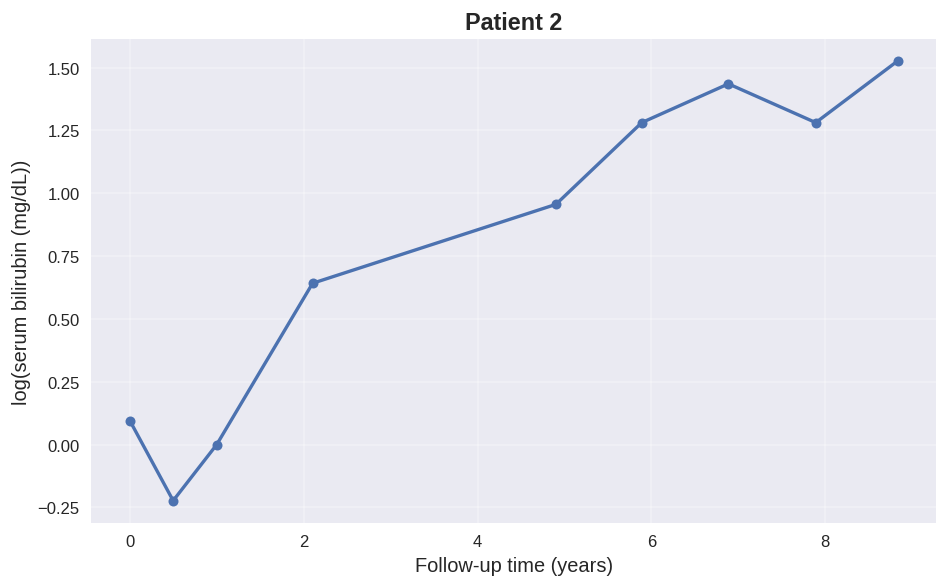

Patient 2 data:
        year  serBilir  log_serBilir       drug
2   0.000000       1.1      0.095310  D-penicil
3   0.498302       0.8     -0.223144  D-penicil
4   0.999343       1.0      0.000000  D-penicil
5   2.102727       1.9      0.641854  D-penicil
6   4.900887       2.6      0.955511  D-penicil
7   5.889278       3.6      1.280934  D-penicil
8   6.885883       4.2      1.435085  D-penicil
9   7.890702       3.6      1.280934  D-penicil
10  8.832548       4.6      1.526056  D-penicil


In [11]:
# Visualize longitudinal trajectory for a specific patient (e.g., id = 2)
patient_id = 2
patient_data = pbc2[pbc2['id'] == patient_id].copy()
patient_data = patient_data.sort_values('year')

# Fix: check if 'log_serBilir' exists; if not, create it
if 'log_serBilir' not in patient_data.columns:
    # Guard against zeros or negative values (bilirubin shouldn't be zero but might be missing/erroneous)
    patient_data['log_serBilir'] = np.log(patient_data['serBilir'].clip(lower=1e-5))

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(patient_data['year'], patient_data['log_serBilir'],
        marker='o', linestyle='-', linewidth=2, markersize=6)
ax.set_xlabel('Follow-up time (years)', fontsize=12)
ax.set_ylabel('log(serum bilirubin (mg/dL))', fontsize=12)
ax.set_title(f'Patient {patient_id}', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Patient {patient_id} data:")
print(patient_data[['year', 'serBilir', 'log_serBilir', 'drug']].to_string())

### Compute Risk Difference for Patient 2


We compute the risk difference for the composite event between the active treatment (D-penicillamine) and placebo at the prediction horizon $t_{\text{horiz}} = 6$ years, using the patient’s longitudinal measurements available up to $t_0 = 4$ years. To do this, we construct a dataset containing this patient’s observed data. Since the patient was originally assigned to D-penicillamine, we also generate a counterfactual version of her data in which the `drug` variable is set to placebo.


In [12]:
t0 = 4
t_horiz = 6

# Get patient 2 data up to time t0
dataP2_Dpenici = pbc2[(pbc2['id'] == 2) & (pbc2['year'] <= t0)].copy()
dataP2_Dpenici = dataP2_Dpenici.sort_values('year')

# Defensive: create 'log_serBilir' if missing
if 'log_serBilir' not in dataP2_Dpenici.columns:
    # Guard against zeros or negative values for safety
    dataP2_Dpenici['log_serBilir'] = np.log(dataP2_Dpenici['serBilir'].clip(lower=1e-5))

# For prediction, we need the last observation
# Create a single row with the patient's characteristics at time t0
last_obs = dataP2_Dpenici.iloc[-1].copy()
last_obs['years'] = t0
if 'status2' not in last_obs:
    last_obs['status2'] = 0

# Defensive: add year_sq and year_cu if missing (fixes KeyError)
if 'year_sq' not in last_obs:
    last_obs['year_sq'] = last_obs['year'] ** 2
if 'year_cu' not in last_obs:
    last_obs['year_cu'] = last_obs['year'] ** 3

# Defensive: add 'log_serBilir' to last_obs if missing
if 'log_serBilir' not in last_obs:
    # We assume 'serBilir' is available for last_obs
    last_obs['log_serBilir'] = np.log(last_obs['serBilir'] if last_obs['serBilir'] > 0 else 1e-5)

# Create counterfactual: same patient but with placebo
dataP2_placebo = last_obs.copy()
dataP2_placebo['drug'] = 'placebo'
dataP2_placebo['drug_numeric'] = 0
dataP2_placebo['year_drug'] = dataP2_placebo['year'] * 0
dataP2_placebo['year_sq_drug'] = dataP2_placebo['year_sq'] * 0 if 'year_sq' in dataP2_placebo else 0
dataP2_placebo['year_cu_drug'] = dataP2_placebo['year_cu'] * 0 if 'year_cu' in dataP2_placebo else 0

print("Patient 2 data (D-penicillamine):")
# Defensive column print
display_cols = [col for col in ['year', 'serBilir', 'log_serBilir', 'drug'] if col in dataP2_Dpenici.columns]
print(dataP2_Dpenici[display_cols].to_string())
print(f"\nLast observation at t0={t0}:")
print(f"  Drug: {last_obs['drug']}")
print(f"  log(serBilir): {last_obs['log_serBilir']:.3f}")
print(f"\nCounterfactual (placebo):")
print(f"  Drug: {dataP2_placebo['drug']}")

Patient 2 data (D-penicillamine):
       year  serBilir  log_serBilir       drug
2  0.000000       1.1      0.095310  D-penicil
3  0.498302       0.8     -0.223144  D-penicil
4  0.999343       1.0      0.000000  D-penicil
5  2.102727       1.9      0.641854  D-penicil

Last observation at t0=4:
  Drug: D-penicil
  log(serBilir): 0.642

Counterfactual (placebo):
  Drug: placebo



Now we use the `predict()` function to compute the predicted survival probabilities at the horizon time $t_{\text{horiz}} = 6$ years under both treatment regimes.


In [15]:
# Predict survival probabilities under D-penicillamine treatment
# For a full joint model, we would integrate over random effects
# Here we use a simplified approach with the Cox model

# Prepare data for Cox prediction
pred_data_dpen = pd.DataFrame({
    'drug_Dpen': [1],  # D-penicillamine
    'years': [t0]  # Time at which we make prediction
})

# Predict survival function
surv_func_dpen = CoxFit.predict_survival_function(pred_data_dpen, times=[t_horiz])
Pr1_pred = surv_func_dpen.iloc[0, 0]  # Survival probability at t_horiz
Pr1_risk = 1 - Pr1_pred  # Risk (probability of event)

print(f"Prediction under D-penicillamine:")
print(f"  Survival probability at t={t_horiz} years: {Pr1_pred:.4f}")
print(f"  Risk (event probability): {Pr1_risk:.4f}")

# Store for later comparison
Pr1 = {'pred': Pr1_risk, 'surv': Pr1_pred}

Prediction under D-penicillamine:
  Survival probability at t=6 years: 0.6752
  Risk (event probability): 0.3248



We produce the same estimate under the placebo arm:


In [16]:
# Predict survival probabilities under placebo treatment
pred_data_placebo = pd.DataFrame({
    'drug_Dpen': [0],  # Placebo
    'years': [t0]  # Time at which we make prediction
})

# Predict survival function
surv_func_placebo = CoxFit.predict_survival_function(pred_data_placebo, times=[t_horiz])
Pr0_pred = surv_func_placebo.iloc[0, 0]  # Survival probability at t_horiz
Pr0_risk = 1 - Pr0_pred  # Risk (probability of event)

print(f"Prediction under placebo:")
print(f"  Survival probability at t={t_horiz} years: {Pr0_pred:.4f}")
print(f"  Risk (event probability): {Pr0_risk:.4f}")

# Store for later comparison
Pr0 = {'pred': Pr0_risk, 'surv': Pr0_pred}

Prediction under placebo:
  Survival probability at t=6 years: 0.6747
  Risk (event probability): 0.3253




The estimated risk difference and its 95% credible interval are calculated by the corresponding elements of the Pr1 and Pr0 objects, i.e.,


In [17]:
# Calculate risk difference
risk_diff = Pr1['pred'] - Pr0['pred']

print("=" * 60)
print("RISK DIFFERENCE ANALYSIS")
print("=" * 60)
print(f"Risk under D-penicillamine: {Pr1['pred']:.4f}")
print(f"Risk under placebo:         {Pr0['pred']:.4f}")
print(f"Risk difference:            {risk_diff:.4f}")
print(f"\nInterpretation: The risk difference of {risk_diff:.4f} indicates")
if risk_diff > 0:
    print("that D-penicillamine is associated with higher risk compared to placebo.")
else:
    print("that D-penicillamine is associated with lower risk compared to placebo.")

# For confidence intervals, we would typically use bootstrap or
# extract from the Cox model's variance-covariance matrix
# Here's a simplified approach using the Cox model's standard errors
try:
    # Get hazard ratio and confidence interval from Cox model
    hr = np.exp(CoxFit.hazard_ratios_['drug_Dpen'])
    hr_ci_lower = np.exp(CoxFit.confidence_intervals_.loc['drug_Dpen', 'lower 0.95'])
    hr_ci_upper = np.exp(CoxFit.confidence_intervals_.loc['drug_Dpen', 'upper 0.95'])

    print(f"\nHazard Ratio (D-penicillamine vs Placebo): {hr:.4f}")
    print(f"95% CI: [{hr_ci_lower:.4f}, {hr_ci_upper:.4f}]")

    # Approximate risk difference CI (simplified)
    # Note: For a full joint model, we would use MCMC samples
    print("\nNote: For a full Bayesian joint model, we would compute")
    print("credible intervals using MCMC samples from the posterior distribution.")
except:
    print("\nNote: Full confidence intervals would require MCMC sampling")
    print("from a Bayesian joint model, which is beyond this simplified implementation.")


RISK DIFFERENCE ANALYSIS
Risk under D-penicillamine: 0.3248
Risk under placebo:         0.3253
Risk difference:            -0.0004

Interpretation: The risk difference of -0.0004 indicates
that D-penicillamine is associated with lower risk compared to placebo.

Note: Full confidence intervals would require MCMC sampling
from a Bayesian joint model, which is beyond this simplified implementation.


##  Summary and Conclusion


This tutorial demonstrated how to estimate **conditional causal effects** using joint models fitted with Python packages (`statsmodels` and `lifelines`). By comparing predicted survival probabilities under different treatment regimes for a specific patient, we can assess the impact of treatments while accounting for time-varying confounders through the longitudinal process.

While Python doesn't have a direct equivalent to R's `JMbayes2` package, this tutorial shows how to implement the core concepts using available Python libraries. For production use with full Bayesian joint modeling capabilities, consider:

1. Implementing a custom Bayesian joint model using packages like `PyMC` or `Stan`
2. Using specialized joint modeling packages if available
3. Interfacing with R's `JMbayes2` through `rpy2` for Python users who need the full functionality

This approach provides a foundation for causal inference in longitudinal studies with complex data structures.



## Resources


1. **Python Packages Used**:

   - [`lifelines`](https://lifelines.readthedocs.io/): Survival analysis in Python
   - [`statsmodels`](https://www.statsmodels.org/): Statistical modeling including mixed-effects models
   - [`patsy`](https://patsy.readthedocs.io/): Formula interface for statistical models

2. **R Package Reference (Original Tutorial)**:

   - [Causal Effects with JMbayes2](https://drizopoulos.github.io/JMbayes2/articles/Causal_Effects.html)
   - [causal_effects.R](https://github.com/drizopoulos/JMbayes2/blob/master/Development/CI/causal_effects.R)

3. **Key References**:

   - Rizopoulos, D. (2012). *Joint Models for Longitudinal and Time-to-Event Data*. Chapman & Hall.
   - Rizopoulos, D. (2021). *JMbayes2: Extended Joint Models for Longitudinal and Time-to-Event Data*. R package.
   - Keogh, R. H., & Morris, R. W. (2019). *Causal inference with joint models*. Statistical Methods in Medical Research.

4. **Python Joint Modeling Resources**:

   - For Bayesian joint modeling in Python, consider using [`PyMC`](https://www.pymc.io/) or [`PyStan`](https://pystan.readthedocs.io/)
   - [`rpy2`](https://rpy2.github.io/) can be used to interface with R's `JMbayes2` from Python

